# **創建驗證集以及測試集**

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 以8:1:1分割成訓練集、驗證集、測試集
def create_sub_dataset(original_images_root, original_labels_root, new_train_images_root, new_train_labels_root, valid_images_root, valid_labels_root, test_images_root, test_labels_root, test_size=0.1, valid_size=0.1):
    # 圖片以及標籤的位址
    original_images = sorted([os.path.join(original_images_root, f) for f in os.listdir(original_images_root) if f.endswith('.jpg')])
    original_labels = sorted([os.path.join(original_labels_root, f) for f in os.listdir(original_labels_root) if f.endswith('.png')])

    # 只保留有對應標籤的圖片
    images = [img for img in original_images if os.path.exists(os.path.join(original_labels_root, os.path.basename(img).replace('.jpg', '.png')))]
    labels = [lbl for lbl in original_labels if os.path.exists(os.path.join(original_images_root, os.path.basename(lbl).replace('.png', '.jpg')))]

    # 總的測試集比例是 test_size
    # 剩下的資料用來分割成訓練集和驗證集
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=42)

    # 剩下的資料中，再以 valid_size / (1 - test_size) 的比例來分割驗證集和訓練集
    valid_size_adjusted = valid_size / (1 - test_size)
    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=valid_size_adjusted, random_state=42)

    # 創建新的訓練集、驗證集與測試集資料夾
    os.makedirs(new_train_images_root, exist_ok=True)
    os.makedirs(new_train_labels_root, exist_ok=True)
    os.makedirs(valid_images_root, exist_ok=True)
    os.makedirs(valid_labels_root, exist_ok=True)
    os.makedirs(test_images_root, exist_ok=True)
    os.makedirs(test_labels_root, exist_ok=True)

    # 將訓練集資料複製到新的資料夾
    for image in train_images:
        shutil.copy(image, os.path.join(new_train_images_root, os.path.basename(image)))
    for label in train_labels:
        shutil.copy(label, os.path.join(new_train_labels_root, os.path.basename(label)))

    # 將驗證集資料轉移
    for image in valid_images:
        shutil.copy(image, os.path.join(valid_images_root, os.path.basename(image)))
    for label in valid_labels:
        shutil.copy(label, os.path.join(valid_labels_root, os.path.basename(label)))
    
    # 將測試集資料轉移
    for image in test_images:
        shutil.copy(image, os.path.join(test_images_root, os.path.basename(image)))
    for label in test_labels:
        shutil.copy(label, os.path.join(test_labels_root, os.path.basename(label)))

original_images_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_original/images"  # 原始訓練集圖片
original_labels_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_original/labels"  # 原始訓練集標籤
new_train_images_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images"  # 新的訓練集圖片
new_train_labels_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/labels"  # 新的訓練集標籤
valid_images_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Validation_dataset/images"  # 驗證集圖片
valid_labels_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Validation_dataset/labels"  # 驗證集標籤
test_images_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Testing_dataset/images"  # 測試集圖片
test_labels_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Testing_dataset/labels"  # 測試集標籤

create_sub_dataset(original_images_root, original_labels_root, new_train_images_root, new_train_labels_root, valid_images_root, valid_labels_root, test_images_root, test_labels_root)


# **資料集擴增**

In [14]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class GeneralDataset(Dataset):
    def __init__(self, image_root, gt_root, img_size, mode='train', augment=False):
        assert mode in ['train', 'val']
        self.img_size = img_size
        self.mode = mode
        self.augment = augment
        self.images = sorted([os.path.join(image_root, f) for f in os.listdir(image_root) if f.endswith('.jpg')])
        self.gts = sorted([os.path.join(gt_root, f) for f in os.listdir(gt_root) if f.endswith('.png')])
        self.filter_files()

        self.img_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.gt_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor()
        ])
        
        self.da_transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=1.0)  # 水平翻轉
            # transforms.RandomVerticalFlip(p=1.0), # 垂直翻轉
            # transforms.Lambda(lambda img: transforms.functional.adjust_brightness(img, 0.5))  # 固定圖像降低亮度50%，注意此時labels不用跟著降低
        ])
        
        # # =======懶得改程式，對應圖像降低亮度50%時，labels不用跟著降低========
        # self.da_transform2 = transforms.Compose([
        # ])
        # # ================================================================

# =====================================================資料集擴增=============================================================
        # 設定擴增後的保存路徑
        self.aug_image_save_path = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/images"
        self.aug_label_save_path = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/labels"

        # 創建保存目錄
        os.makedirs(self.aug_image_save_path, exist_ok=True)
        os.makedirs(self.aug_label_save_path, exist_ok=True)

        if self.mode == 'train' and self.augment:
            self.augment_and_save_images()
        else:
            self.load_augmented_images()

    def augment_and_save_images(self):
        base_index = 2010944 # 下一個要創建的名稱
        for i, (image_path, gt_path) in enumerate(zip(self.images, self.gts)):
            image = Image.open(image_path).convert('RGB')
            gt = Image.open(gt_path).convert('L')

            # 進行資料擴增
            aug_image = self.da_transform(image)
            aug_gt = self.da_transform(gt)
            
            # # =======懶得改程式，對應圖像降低亮度50%時，labels不用跟著降低==============
            # aug_gt = self.da_transform2(gt) # 對應圖像降低亮度50%時，labels不用跟著降低
            # # ======================================================================

            # 生成擴增後的名稱
            base_name = os.path.basename(image_path)
            new_index = base_index + i
            if "TRA_RI" in base_name:
                new_name = f"TRA_RI_{new_index:07d}.jpg"
            else:
                new_name = f"TRA_RO_{new_index:07d}.jpg"

            # 保存擴增後的影像和標籤
            aug_img_path = os.path.join(self.aug_image_save_path, new_name)
            aug_gt_path = os.path.join(self.aug_label_save_path, new_name.replace(".jpg", ".png"))
            aug_image.save(aug_img_path)
            aug_gt.save(aug_gt_path)

            print(f"Saved augmented image to {aug_img_path} and label to {aug_gt_path}")
# =============================================================================================================================

    def load_augmented_images(self):
        aug_images = sorted([os.path.join(self.aug_image_save_path, f) for f in os.listdir(self.aug_image_save_path) if f.endswith('.jpg')])
        aug_gts = sorted([os.path.join(self.aug_label_save_path, f) for f in os.listdir(self.aug_label_save_path) if f.endswith('.png')])
        self.images.extend(aug_images)
        self.gts.extend(aug_gts)

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')
        gt = Image.open(self.gts[index]).convert('L')

        image = self.img_transform(image)
        gt = self.gt_transform(gt)

        return image, gt
    
    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images, gts = [], []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images, self.gts = images, gts

    def __len__(self):
        return len(self.images)

# 測試資料集
train_images_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images"  # 原始訓練集圖片
train_labels_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/labels"  # 原始訓練集標籤
dataset = GeneralDataset(train_images_root, train_labels_root, img_size=256, mode='train', augment=True)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 測試讀取資料
for images, gts in dataloader:
    print(images.size(), gts.size())
    break


Saved augmented image to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/images/TRA_RI_2010944.jpg and label to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/labels/TRA_RI_2010944.png
Saved augmented image to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/images/TRA_RI_2010945.jpg and label to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/labels/TRA_RI_2010945.png
Saved augmented image to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/images/TRA_RI_2010946.jpg and label to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/labels/TRA_RI_2010946.png
Saved augmented image to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_brightness50%/images/TRA_RI_2010947.jpg and label to /

# **合併擴增後訓練集**

In [22]:
import os
import shutil

def copy_images(src_folder, dst_folder):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    
    for filename in os.listdir(src_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            src_file = os.path.join(src_folder, filename)
            dst_file = os.path.join(dst_folder, filename)
            shutil.copyfile(src_file, dst_file)
            print(f'Copied {src_file} to {dst_file}')

src_folder = '/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images'
dst_folder = '/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined/images'

copy_images(src_folder, dst_folder)


Copied /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images/TRA_RO_2003587.jpg to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined/images/TRA_RO_2003587.jpg
Copied /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images/TRA_RI_2002114.jpg to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined/images/TRA_RI_2002114.jpg
Copied /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images/TRA_RO_2003273.jpg to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined/images/TRA_RO_2003273.jpg
Copied /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images/TRA_RI_2000966.jpg to /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined/images/TRA_RI_2000966.jpg
Copied /home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset/images/TRA_RI_2000763.jpg to /home/ttsai/Drone_contest_

# **查看總資料集數量**

In [23]:
import os
from torch.utils.data import Dataset, DataLoader


# 指定 training set 和 validation set 的路徑
tr_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Training_dataset_divided_expand_combined"
val_root = "/home/ttsai/Drone_contest_2/Dataset_for_Contest2/Validation_dataset"

# 使用 DataLoader 來包裝 training set 和 validation set
# - mode: 設置數據集的模式，設定為 "train "則會做資料擴增
tr_datastet = GeneralDataset(image_root=os.path.join(tr_root, "images"),
                gt_root=os.path.join(tr_root, "labels"),
                img_size=224, mode="train")
val_datastet = GeneralDataset(image_root=os.path.join(val_root, "images"),
                gt_root=os.path.join(val_root, "labels"),
                img_size=224, mode="val")

# 建立DataLoader來加載 training set 和 validation set
batch_size = 12
tr_loader = DataLoader(dataset = tr_datastet, batch_size=batch_size, shuffle=True,
                  num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset = val_datastet, batch_size=batch_size, shuffle=True,
                  num_workers=4, pin_memory=True)

# 可以在這裡確認資料集和加載器是否正確設置
print(f"Training dataset size: {len(tr_datastet)}")
print(f"Validation dataset size: {len(val_datastet)}")

# 測試 DataLoader 加載
for images, gts in tr_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"GT batch shape: {gts.shape}")
    break

Training dataset size: 16560
Validation dataset size: 3727
Image batch shape: torch.Size([12, 3, 224, 224])
GT batch shape: torch.Size([12, 1, 224, 224])


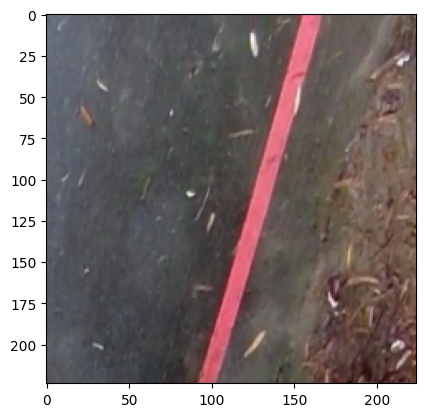

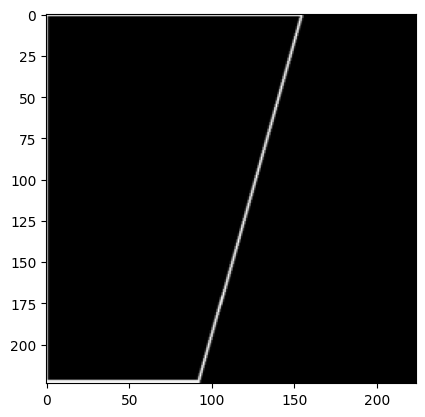

In [29]:
import numpy as np
from matplotlib import pyplot as plt
# 檢查 DataLoader 是否成功載入 image 和 ground truth
data_iter = iter(tr_loader)
images, labels = next(data_iter)


image, label = images[0], labels[0]


image = image.numpy()
label = label.numpy()
image = np.transpose(image, (1, 2, 0))
label = np.transpose(label, (1, 2, 0))

if image.min() < 0 or image.max() > 1:
    image = (image - image.min()) / (image.max() - image.min())
plt.imshow(image)
plt.show()
plt.imshow(label, cmap='gray')
plt.show()